In [1]:
#meta 5/16/2022 ARIMA Model for Time Series Forecasting in Python
#Author: Jason Brownlee on January 9, 2017
#src https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

#history
# 5/13/2022 TUTORIAL
#      With a small dataset

#References
#strptime()
# refer to https://www.programiz.com/python-programming/datetime/strptime

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA


In [3]:
#-------- GLOBAL VARS --------
#strptime()
# refer to https://www.programiz.com/python-programming/datetime/strptime

#fn: parse datetime field
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

plt.rcParams['figure.figsize'] = (16, 8)

CSV_PATH = "my_data/shampoo-sales.csv"

# ARIMA Model for Time Series Forecasting
Work by  Jason Brownlee https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/  

AutoRegressive Integrated Moving Average is is a class of statistical models for analyzing and forecasting time series data.  
- About the ARIMA model the parameters used and assumptions made by the model  
- How to fit an ARIMA model to data and use it to make forecasts  
- How to configure the ARIMA model on your time series problem  

The ARIMA model can be used to forecast future time steps.



Key aspects  
- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.  
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.  
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of `ARIMA(p,d,q)` where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model defined:

- p: The number of lag observations included in the model, also called the lag order.  
- d: The number of times that the raw observations are differenced, also called the degree of differencing.  
- q: The size of the moving average window, also called the order of moving average.  

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

## 0. Load dataset
This dataset describes the monthly number of sales of shampoo over a 3 year period.

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

In [4]:
# load dataset
#series = read_csv('my_data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = pd.read_csv(CSV_PATH, header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
series.index = series.index.to_period('M')
print(series.shape)
print(series.head())


(36,)
Month
1901-01    266.0
1901-02    145.9
1901-03    183.1
1901-04    119.3
1901-05    180.3
Freq: M, Name: Sales, dtype: float64


### 0.1 EDA
look at an autocorrelation plot of the time series

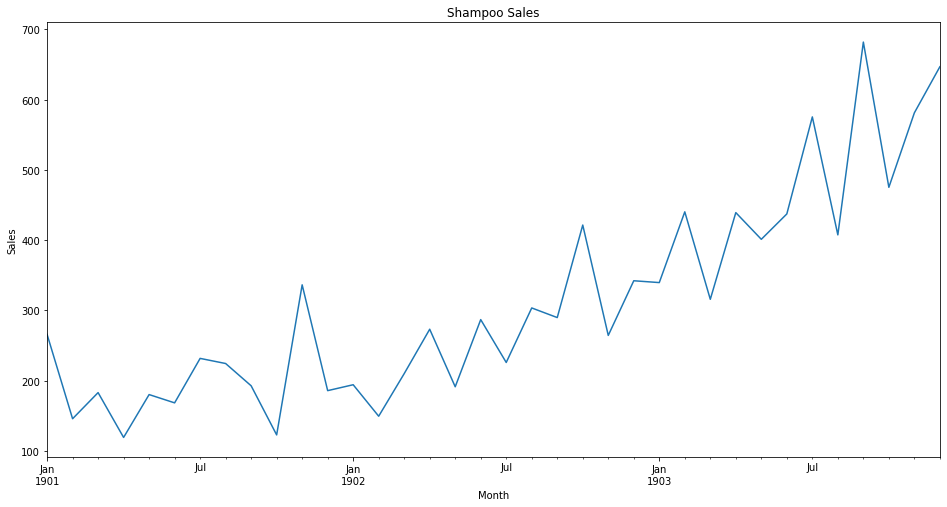

In [5]:
# vis data
series.plot(title = 'Shampoo Sales')
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

the Shampoo Sales dataset has a clear trend -> Modeling: suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

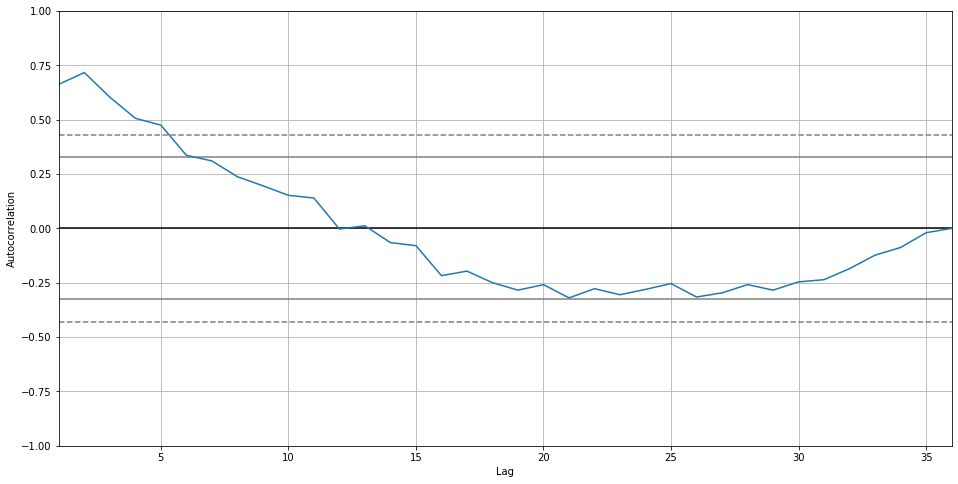

In [6]:
#plots the autocorrelation for a large number of lags in ts
autocorrelation_plot(series)
plt.show()

Plot shows a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags -> Modeling: a good starting point for the AR parameter of the model may be 5.  

## 2. How to Model
`statsmodels` library provides the capability to fit an ARIMA model.

### 2.0 Fit an ARIMA model
fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors.

`ARIMA(5,1,0)` model parameters:  
- AR set the lag value to 5 for autoregression  
- I use a difference order of 1 to make the time series stationary  
- MA use a moving average model of 0  

In [7]:
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Tue, 17 May 2022   AIC                            408.969
Time:                        15:07:55   BIC                            418.301
Sample:                    01-31-1901   HQIC                           412.191
                         - 12-31-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

Summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.

##### Residual errors



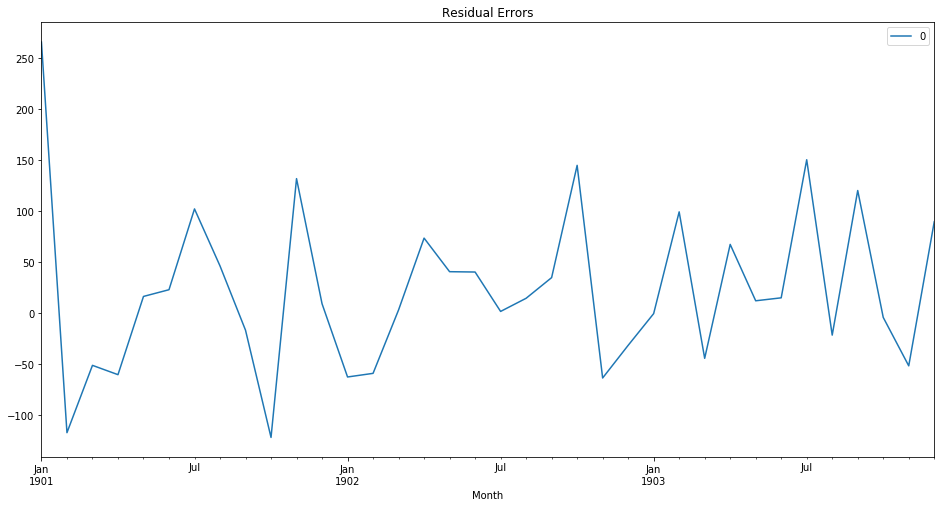

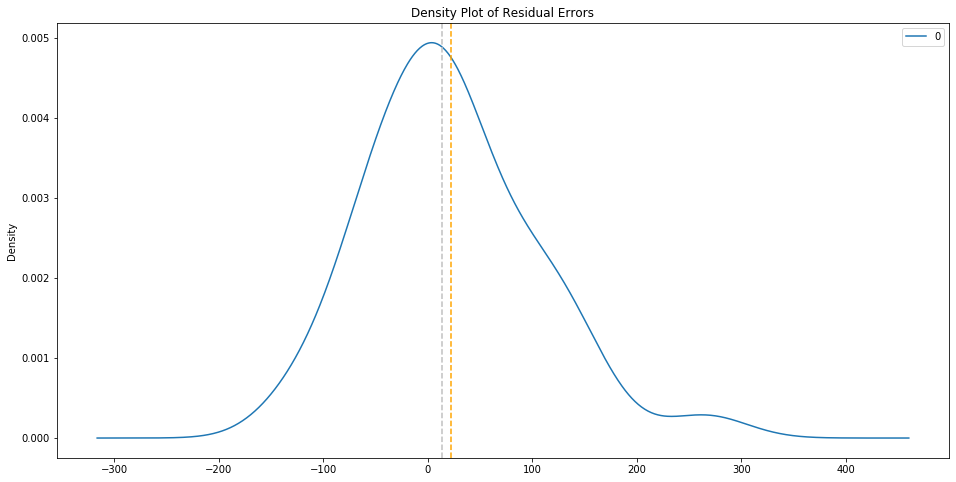

In [8]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title = 'Residual Errors')
plt.show()

# density plot of residuals
residuals.plot(kind='kde', title = 'Density Plot of Residual Errors')
plt.axvline(residuals.describe().loc['mean',0], color ='orange', linestyle ='--')
plt.axvline(residuals.describe().loc['50%',0], color ='silver', linestyle ='--')
plt.show()

- Line plot of the residual errors suggests that there may still be some trend information not captured by the model  
- Density plot of the residual errors suggests the errors are Gaussian, but may not be centered on zero

In [9]:
# summary stats of residuals
print(residuals.describe())

                0
count   36.000000
mean    21.936145
std     80.774430
min   -122.292029
25%    -35.040859
50%     13.147219
75%     68.848286
max    266.000000


The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

## 1. Prep data
We used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

In [10]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]


### 2.1 Create a Model
ARIMA modeling to make forecasts

`forecast()` function performs a one-step forecast using the model

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

In [11]:
# 1)fit the model on train ds, and 2)generate a prediction for each element on the test ds
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=343.272180, expected=342.300000
predicted=293.329674, expected=339.700000
predicted=368.668956, expected=440.400000
predicted=335.044741, expected=315.900000
predicted=363.220221, expected=439.300000
predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365674, expected=575.500000
predicted=459.415021, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231274, expected=475.300000
predicted=672.914943, expected=581.300000
predicted=531.541449, expected=646.900000


##### Evaluate Model
Calculate RMSE for the predictions, providing a point of comparison for other ARIMA configurations

Test RMSE: 89.021


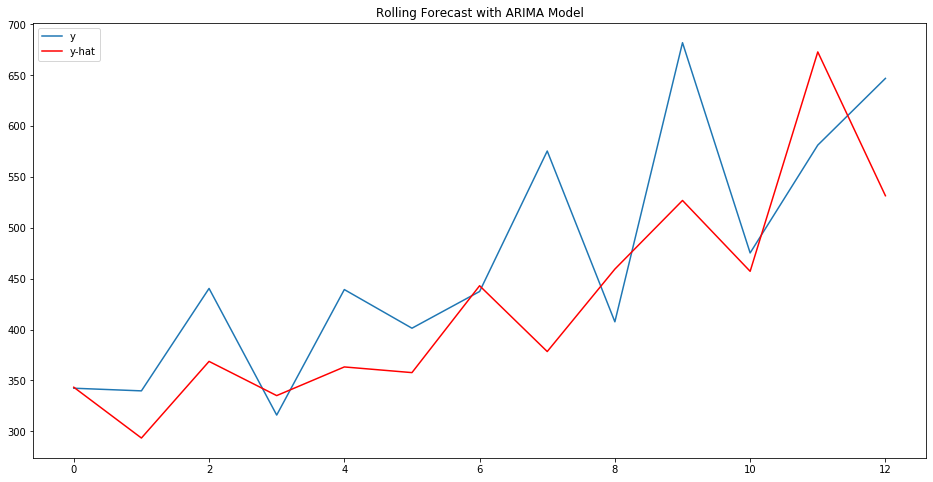

In [12]:
# evaluate forecasts on test ds
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test, label = 'y')
plt.plot(predictions, color='red', label= 'y-hat')
plt.title('Rolling Forecast with ARIMA Model')
plt.legend(loc='upper left') #loc='best', handleheight = 7, 
plt.show()

Plot shows the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

The model could use further tuning of the `p`, `d`, and maybe even the `q` parameters.


##### Better
We can use the `predict()` function on the `ARIMAResults` object (https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html) to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as `start=101`, `end=101`. This would return an array with one element containing the prediction.

We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (`d>0` when configuring the model). This can be specified by setting the `typ` argument to the value ‘levels’: `typ=’levels’`.

## Configuring an ARIMA Model
The classical approach for fitting an ARIMA model is to follow the Box-Jenkins Methodology (https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method).  This is a process that uses time series analysis and diagnostics to discover good parameters for the ARIMA model.

## Summary
The steps of this process are:

- Model Identification. Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.  
- Parameter Estimation. Use a fitting procedure to find the coefficients of the regression model.  
- Model Checking. Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.  

The process is repeated until either a desirable level of fit is achieved on the in-sample or out-of-sample observations (e.g. training or test datasets).

References:  
How to Grid Search ARIMA Model Hyperparameters  (https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)